In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import gridspec
from matplotlib import pylab as plt

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

### Define plotting helper functions

# Chapter 5 - THE MANY VARIABLES & THE SPURIOUS WAFFLES

## End of Chapter Problems

In making my implementations and problem solutions for this chapter I will be making use of the "causalgraphicalmodels" package. This allows for straight forward visualisations of the DAGs.

### 5E1.
Which of the linear models below are multiple linear regressions?

(1) µi = α + βxi

(2) µi = $β_x$xi + $β_z$zi

(3) µi = α + β(xi − zi)

(4) µi = α + $β_x$xi + $β_z$zi

#### Answer 
 2) & 4) & 3)?. Answer 1 only contains a single variable and answer 3 sums is multiple regression where the coefficient of xi and zi are constrained to be of equal magnitude but opposite sign. 

### 5E2.
Write down a multiple regression to evaluate the claim: Animal diversity is linearly related to latitude, but only after controlling for plant diversity. You just need to write down the model definition.

#### Answer 
 $Ad_i = \alpha + \beta_{L} L_i  + \beta_{Pd} Pd$

where Ad and Pd mean animal diversity and plant diversity respectively, and L denotes Latitude.

### 5E3.
Write down a multiple regression to evaluate the claim: Neither amount of funding nor size of laboratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree. Write down the model definition and indicate which side of zero each slope parameter should be on.

#### Answer 
 Letting F denote funding and S denote laboratory size, then the model is that
$T_i = \alpha + \beta_f F_i + \beta_s S_i$

and the claim is that both $\beta_f \& \beta_s$ are positively associated with time to degree.

### 5E4.
Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C
and D. Let Ai be an indicator variable that is 1 where case i is in category A. Also suppose Bi, Ci, and Di for the other categories. Now which of the following linear models are inferentially equivalent
ways to include the categorical variable in a regression? Models are inferentially equivalent when it’s possible to compute one posterior distribution from the posterior distribution of another model.

(1) µi = α + β_AAi + β_B Bi + β_D Di

(2) µi = α + $β_A$Ai + $β_B$Bi + $β_C$Ci + $β_D$Di

(3) µi = α + $β_B$Bi + $β_C$Ci + $β_D$Di

(4) µi = $α_A$Ai + $α_B$Bi + $α_C$Ci + $α_D$Di

(5) µi = $α_A$(1 − $B_i$ − $C_i$ − $D_i$) + $α_B$Bi + $α_C$Ci + $α_D$Di

#### Answer 
 Models 1,3,4,5 are equivalent. As A,B,C,D are all values representing the category variable, for any given case i, this implies that only one of the indicator variables in the above expressions can equal one for any given instance. This in turn implies that eq.1 is equivalent to eq.4. Why? Inspecting eq.1, if instance i is in category c, the $\mu_i = \alpha$. For eq.4, $\mu_i = \alpha_c$. Similarly $\mu_i$ will equal $\beta_c$ and $\alpha_c$ in equations 2 and 5 respectively. Eq's 1,3,4,5 all have 4 parameters within them, that can be uniquely transformed into the parameters of the other equations. Eq.2 however contains an additional parameter, the intercept, which cannot be obtained by transforming the other equations.



### 5M1.
Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

#### Answer 
 Let's consider an example, which I have no idea whether it's true or not. Let's take parental IQ, parental income and the IQ of their children. Let's imagine a world where parental IQ causes both child's IQ and parents income, but the parent's income has absolutely no causal effect on a child's IQ. See the causal diagram below. Again, I'm not really claiming this is true, it's just a conceivable toy model. In this world, the correlation between a child's IQ and parental income would be completely spurious, both actually being caused by the parent's IQ. One could imagine that parents with higher IQs are able to get better incomes due to their valuable asset of high cognitive capacity. Let's further suppose that they are also able to increase their child's IQ either through heritability , or because parents with higher IQs are able to give their children better environments. I'm agnostic about what is true in the real world, but it's vaguely conceivable when one doesn't have familiarity with the relevant literature. Alas, I'm just making a toy model.

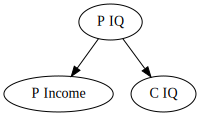

In [3]:
sprinkler = CausalGraphicalModel(
    nodes=["P IQ", "C IQ", "P Income"], edges=[("P IQ", "P Income"), ("P IQ", "C IQ")]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

In [4]:
# synthesise fake data representing this model
PIQ = np.random.normal(loc=100, scale=15, size=100)  # set the parental IQ
# set parental annual income
PIN = np.random.normal(loc=PIQ * 100 + 70000, scale=2000)
# set child IQ as being determined by parental IQ
CIQ = np.random.normal(loc=PIQ, scale=7.5)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

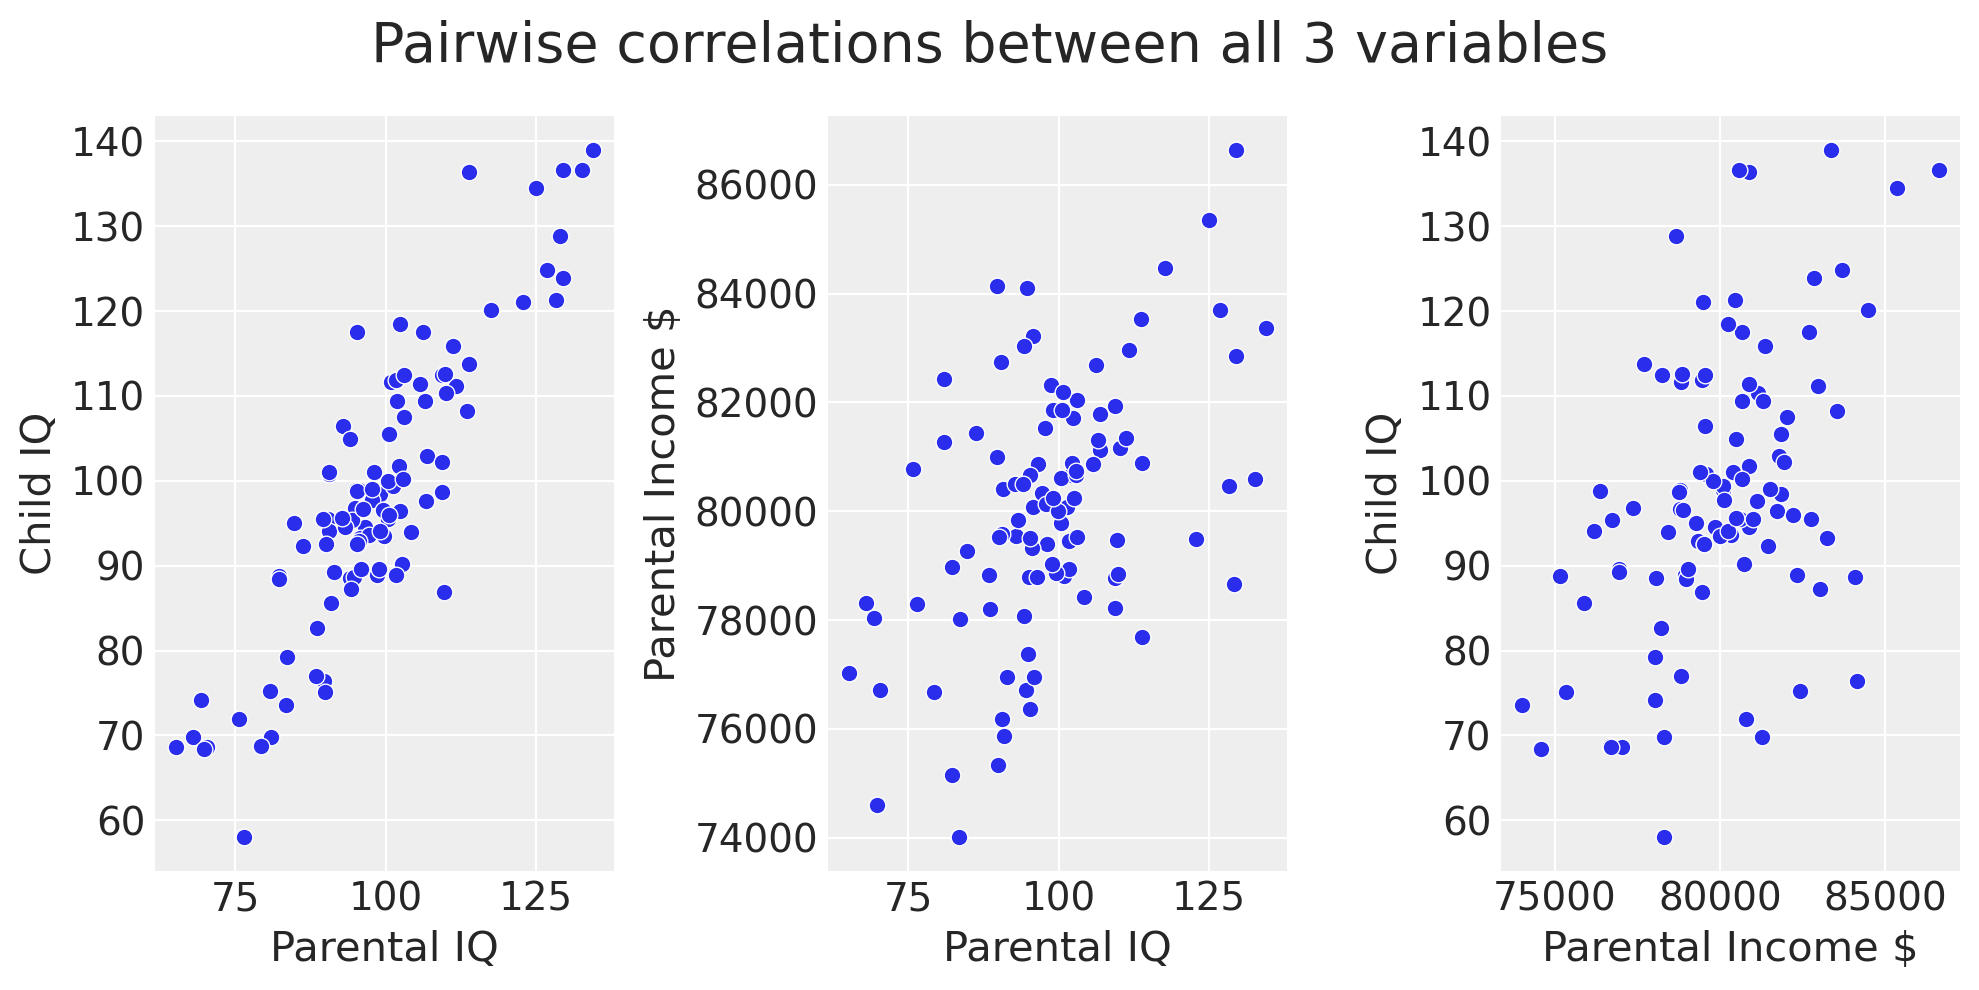

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle("Pairwise correlations between all 3 variables", fontsize=20)
sns.scatterplot(PIQ, CIQ, ax=axs[0])
axs[0].set_xlabel("Parental IQ")
axs[0].set_ylabel("Child IQ")
sns.scatterplot(PIQ, PIN, ax=axs[1])
axs[1].set_xlabel("Parental IQ")
axs[1].set_ylabel("Parental Income $")
sns.scatterplot(PIN, CIQ, ax=axs[2])
axs[2].set_xlabel("Parental Income $")
axs[2].set_ylabel("Child IQ")
plt.tight_layout();

We can now perform our linear regressions on these models. I'll just use pymc3 MCMC tool to estimate this and not bother with Laplace's method for now. I'll fit two linear models to the data, both of which will attempt to predict child IQ. The first model will use just parental income and the second will make use of both parental income and parental IQ. As I generated this data in such a way as for the parental income to be spurious, we should see the first model have a positive slope parameter and the second model should have zero slope parameter for the parental income variable, as we're controlling for the true cause. More formally

### Model 1



$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(x_i - \bar{x})$

$\alpha$ ~ $N(100,10)$

$\beta$ ~ $Log-Normal(0,1)$ The relationships are presumed to have positive slopes, as seen by eyeing the scatter plots

$\sigma$ ~ $Unif(0,20)$

### Model 2

$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_{PIN} (PIN_i - \bar{PIN}) + \beta_{PIQ}(PIQ_i - \bar{PIQ})  $

$\alpha$ ~ $N(100,10)$

$\beta_{PIN}$ ~ $N(0,1)$ This our priors must reflect the fact that we think the relationship could be zero or slightly negative when we factor for other variables. This we change from a log-normal to a normal prior

$\beta_{PIQ}$ ~ $N(0,1)$

$\sigma$ ~ $Unif(0,20)$


In both of the above models, the mean of the $\alpha$ distribution is chosen to be around 100 as the $\alpha$ is the mean IQ of a child for a mean parental value. IQ test are configured to have a mean value of 100, so we should expect the mean to be somewhere around this value.

where $mean_i, sigma_i =100,15$ for IQ predictions. This makes sense relative to how IQ is defined. $mean_i, sigma_i = \$ 80,000, \$ 10,000$ for income predictions, these are just reasonable ideas based on income.

In [6]:
# scale the parental income data
Scale_PIN = (PIN - np.mean(PIN)) / np.std(PIN)
Scale_PIQ = (PIQ - np.mean(PIQ)) / np.std(PIQ)

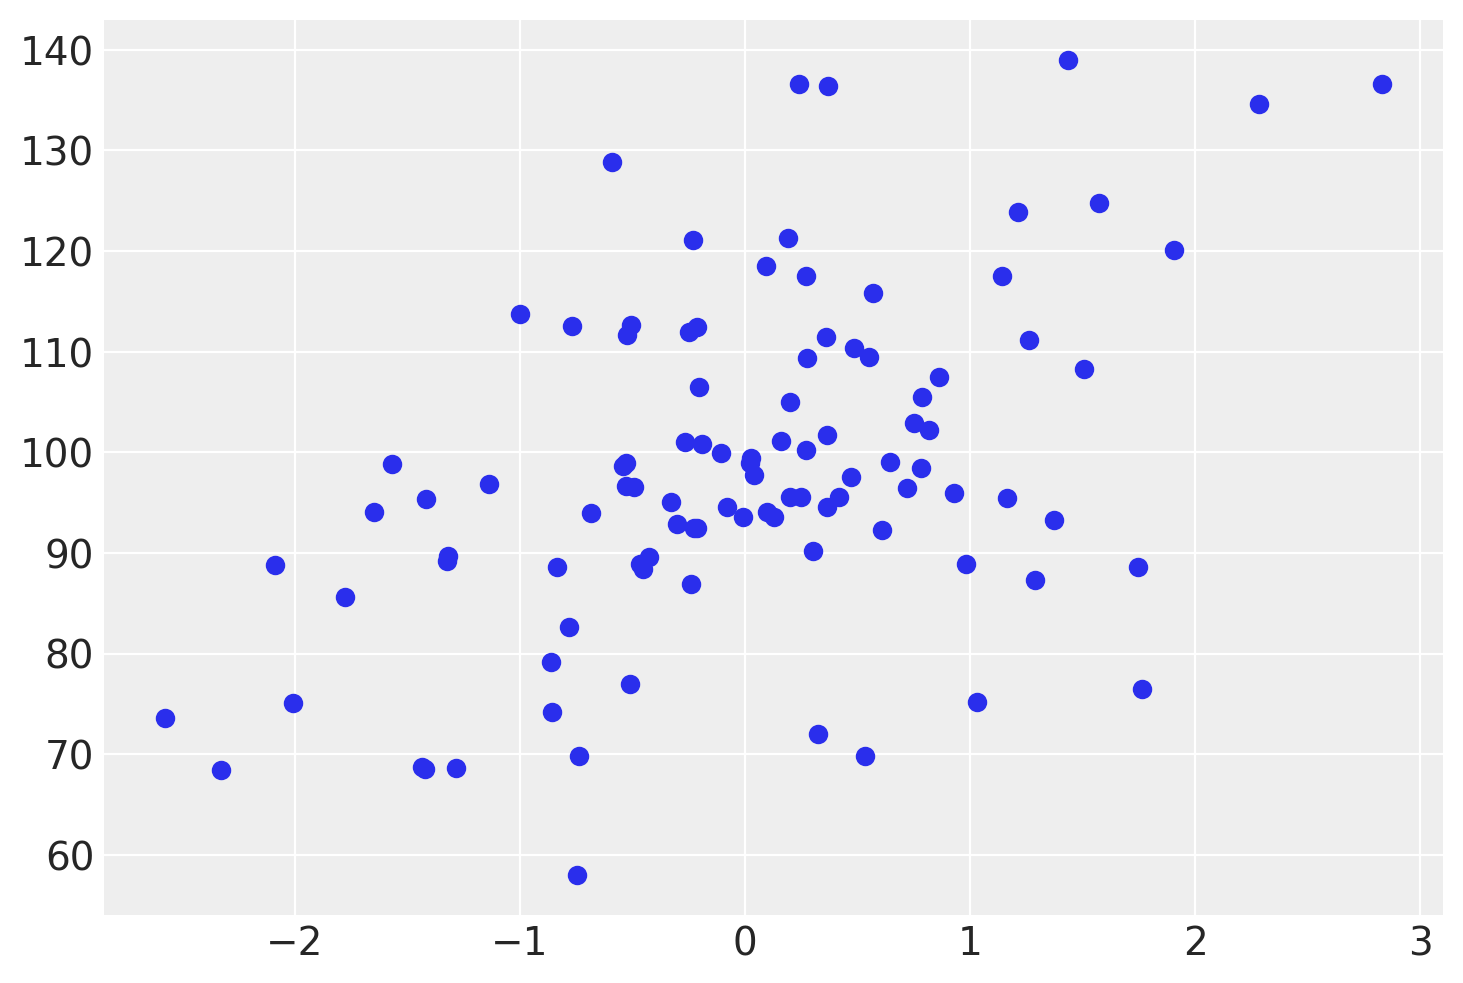

In [7]:
plt.scatter(Scale_PIN, CIQ);

In [8]:
# fit single predictor linear regression
with pm.Model() as one_pred:
    alpha = pm.Normal("alpha", mu=0, sd=15)  # prior on alpha
    beta = pm.Normal("beta", mu=0, sd=5)  # prior on beta
    sigma = pm.Uniform("sigma", 0, 50)  # prior on sigma
    mu = alpha + beta * (Scale_PIN)
    ChildIQ = pm.Normal("ChildIQ", mu=mu, sd=sigma, observed=CIQ)  # likelihood of the data
    sample = pm.sample(
        draws=250, chains=4, return_inferencedata=True
    )  # 1000 random samples on 4 chains
az.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,97.395,1.475,94.825,99.561,0.042,0.030,1240.0,1240.0,1268.0,634.0,1.00
beta,7.427,1.533,5.085,9.887,0.045,0.033,1181.0,1088.0,1188.0,689.0,1.01
sigma,15.007,1.082,13.448,16.777,0.032,0.023,1121.0,1119.0,1117.0,572.0,1.00


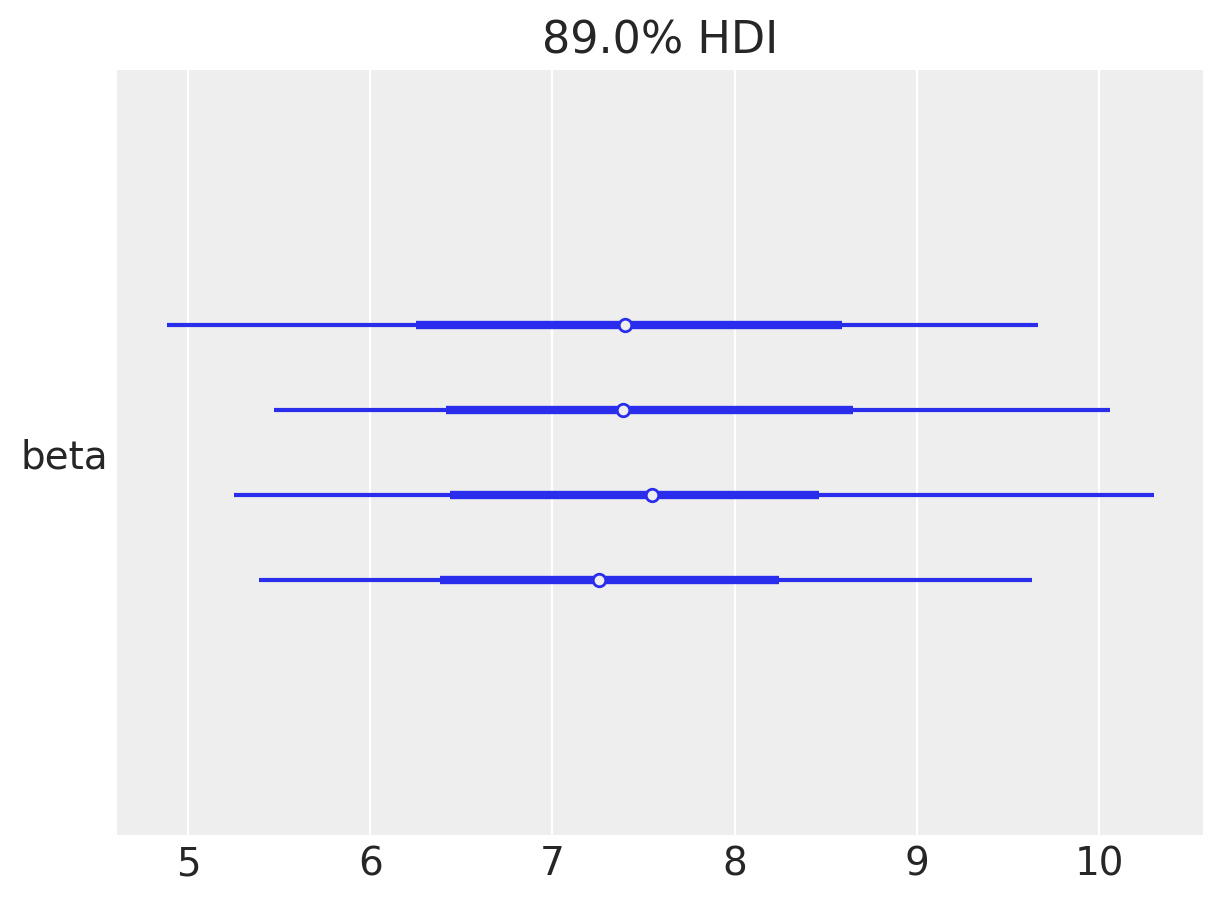

In [9]:
az.plot_forest(sample, var_names=["beta"]);

We can see that there's a relatively strong association between parental income and child's IQ if we don't factor any other variables into the data. Now let's factor in both variables together

In [10]:
# running a multivariate linear regression
with pm.Model() as Linretwo_pred:
    alpha = pm.Normal("alpha", mu=0, sd=15)  # prior on alpha
    beta1 = pm.Normal("beta1", mu=0, sd=5)  # prior on beta1
    beta2 = pm.Normal("beta2", mu=0, sd=5)  # prior on beta2
    sigma = pm.Uniform("sigma", 0, 50)  # prior on sigma
    mu = alpha + beta1 * Scale_PIN + beta2 * Scale_PIQ
    ChildIQ = pm.Normal("ChildIQ", mu=mu, sd=sigma, observed=CIQ)  # likelihood of the data
    sample = pm.sample(
        draws=250, chains=4, return_inferencedata=True
    )  # 1000 random samples on 4 chains
az.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta2, beta1, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,98.079,0.840,96.693,99.338,0.025,0.018,1106.0,1105.0,1111.0,743.0,1.02
beta1,0.998,0.876,-0.264,2.498,0.029,0.022,883.0,812.0,881.0,786.0,1.01
beta2,13.877,0.913,12.512,15.369,0.031,0.022,866.0,866.0,872.0,656.0,1.00
sigma,8.032,0.593,7.036,8.898,0.017,0.012,1224.0,1210.0,1236.0,637.0,1.00


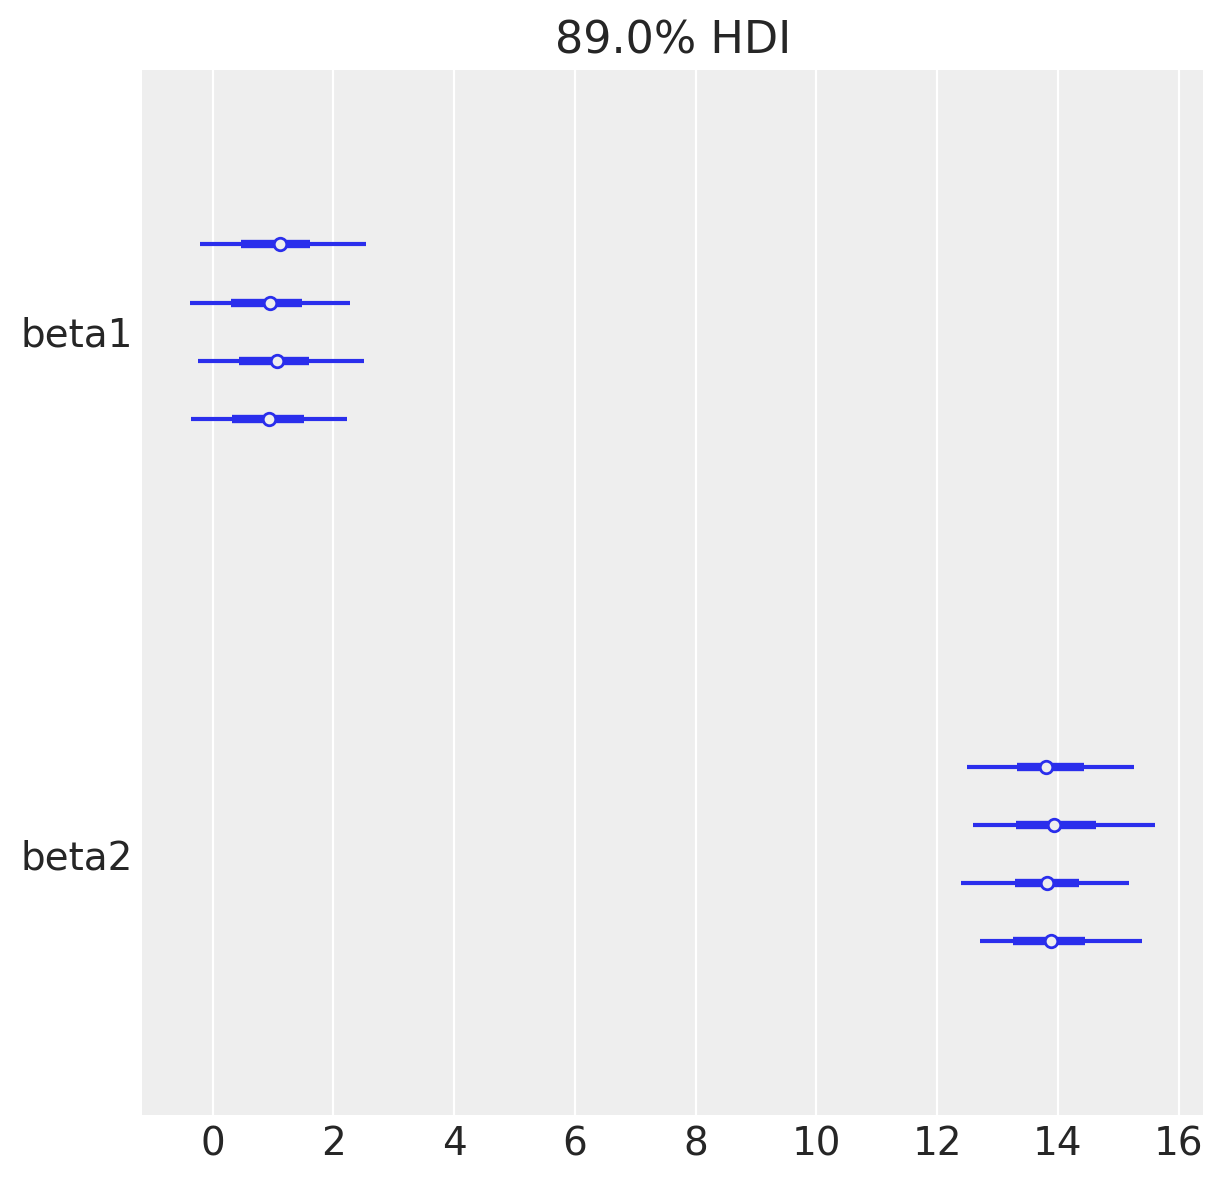

In [11]:
az.plot_forest(sample, var_names=["beta1", "beta2"]);

By inspecting the posterior credible intervals it can be seen that $\beta_1$ is now consistent with being being roughly equal to zero, whilst $\beta_2$ does not. This is consistent with identifying the spurious relationship that was baked into the model.

### 5M2.

Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another.

#### Answer 
 I'm going to be boring on this one and just call the variables X,Y,Z. The causal diagram below shows what has a causal impact on what else. Here we will make X and Y be inversely correlated, but make X and Y both have a positive causal relationship with Z.

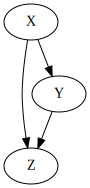

In [12]:
Relation = CausalGraphicalModel(nodes=["X", "Y", "Z"], edges=[("X", "Y"), ("X", "Z"), ("Y", "Z")])

# draw return a graphviz `dot` object, which jupyter can render
Relation.draw()

I'll fit 2 models to investigate the effect of X on Z. The univaritae and then the multivariate.

### Model 1



$Z$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta(X - \bar{X})$

$\alpha$ ~ $N(0,1)$

$\beta$ ~ $N(0,1)$ The relationships are presumed to have positive slopes, as seen by eyeing the scatter plots

$\sigma$ ~ $Unif(0,5)$

### Model 2

$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_{X} (X - \bar{X}) + \beta_{Y}(Y - \bar{Y})  $

$\alpha$ ~ $N(1,10)$

$\beta_{X}$ ~ $N(0,1)$ This our priors must reflect the fact that we think the relationship could be zero or slightly negative when we factor for other variables. This we change from a log-normal to a normal prior

$\beta_{Y}$ ~ $N(0,1)$

$\sigma$ ~ $Unif(0,10)$


In [13]:
# simultate the data
X = np.random.normal(size=50)
Y = np.random.normal(loc=-X)
Z = np.random.normal(2 * X + 2 * Y)

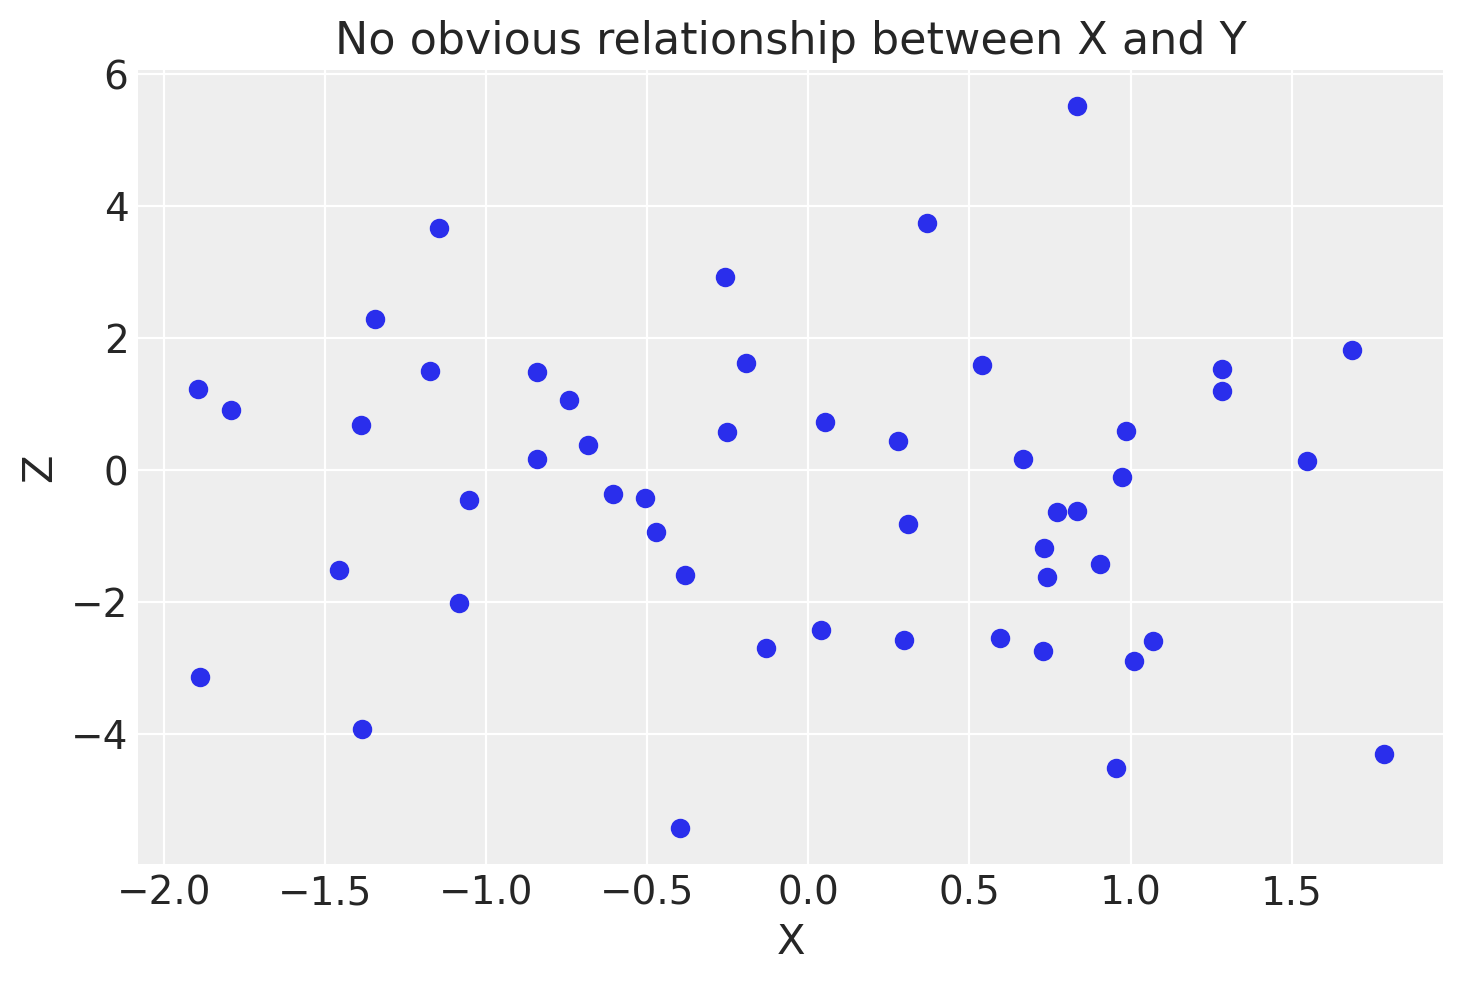

In [14]:
plt.scatter(X, Z)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("No obvious relationship between X and Y");

In [15]:
# Fit the model
with pm.Model() as Linreg:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta = pm.Normal("beta", mu=0, sd=1)  # prior on beta
    sigma = pm.Uniform("sigma", 0, 10)  # prior on sigma
    mu = alpha + beta * (X - np.mean(X))
    Z_vals = pm.Normal("Z_vals", mu=mu, sd=sigma, observed=Z)  # likelihood of the data
    mean_q = pm.find_MAP()
    # print(mean_q)
    # find the hessian matrix
    Hess = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])
    sample = pm.sample(
        draws=250, chains=4, return_inferencedata=True
    )  # 1000 random samples on 4 chains
az.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.312,0.302,-0.793,0.175,0.009,0.007,1152.0,843.0,1160.0,777.0,1.00
beta,-0.190,0.313,-0.720,0.271,0.009,0.008,1236.0,713.0,1243.0,777.0,1.01
sigma,2.324,0.254,1.886,2.687,0.008,0.006,942.0,887.0,1002.0,538.0,1.00


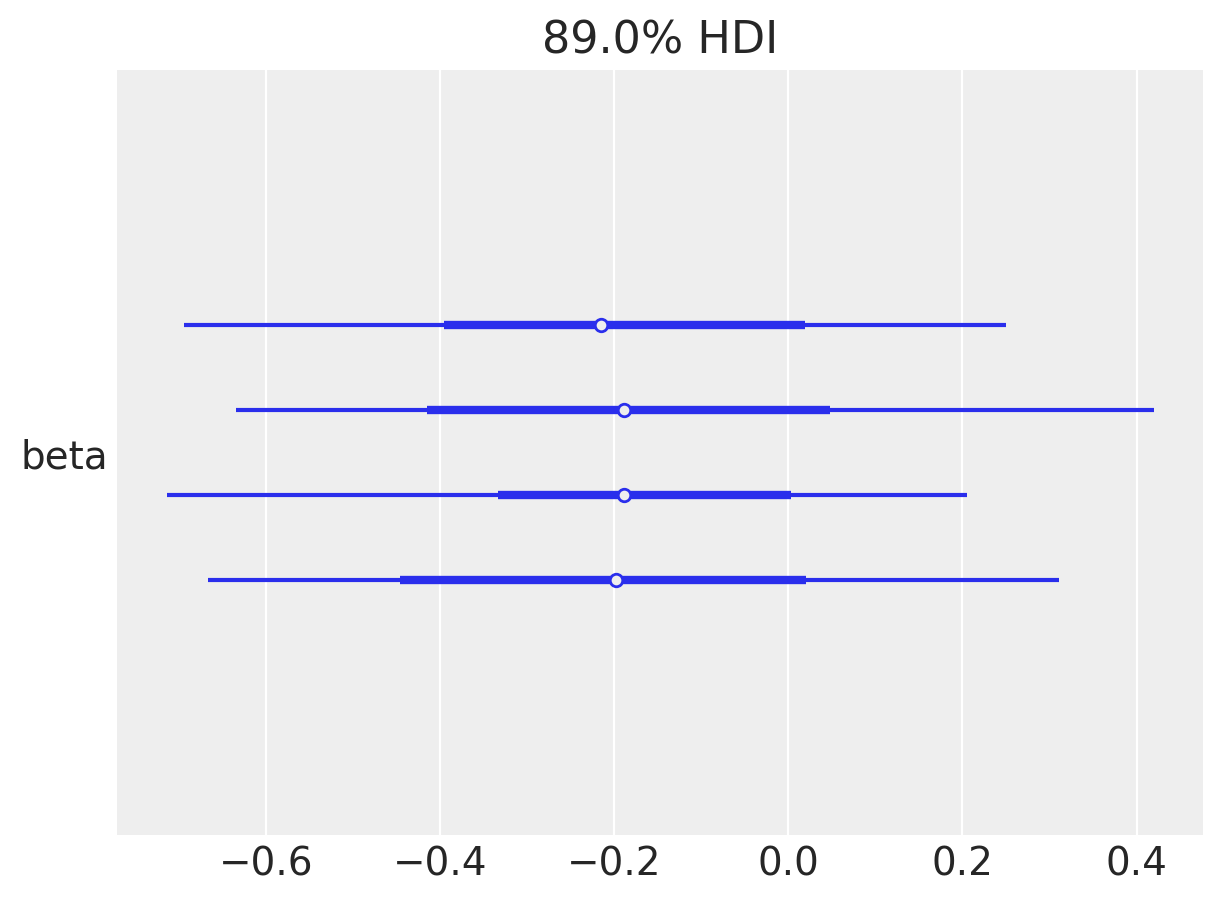

In [16]:
az.plot_forest(sample, var_names=["beta"]);

Clearly this looks like the there is very little evidence for an association between X and Z, as the $\beta$ hpdi show considerable overlap with zero.

In [17]:
# Fit the multivariate model
with pm.Model() as Linreg:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_x = pm.Normal("beta_x", mu=0, sd=1)  # prior on beta_x
    beta_y = pm.Normal("beta_y", mu=0, sd=1)  # prior on beta_y
    sigma = pm.Uniform("sigma", 0, 10)  # prior on sigma
    mu = alpha + beta_x * (X - np.mean(X)) + beta_y * (Y - np.mean(Y))
    Z_vals = pm.Normal("Z_vals", mu=mu, sd=sigma, observed=Z)  # likelihood of the data
    mean_q = pm.find_MAP()
    sample = pm.sample(
        draws=250, chains=4, return_inferencedata=True
    )  # 1000 random samples on 4 chains
az.summary(sample)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_y, beta_x, alpha]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.337,0.171,-0.633,-0.102,0.006,0.004,778.0,778.0,805.0,692.0,1.00
beta_x,2.043,0.267,1.621,2.468,0.009,0.007,824.0,824.0,825.0,661.0,1.01
beta_y,1.985,0.182,1.709,2.273,0.006,0.005,809.0,807.0,805.0,711.0,1.00
sigma,1.151,0.126,0.946,1.325,0.005,0.003,753.0,753.0,748.0,654.0,1.00


array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

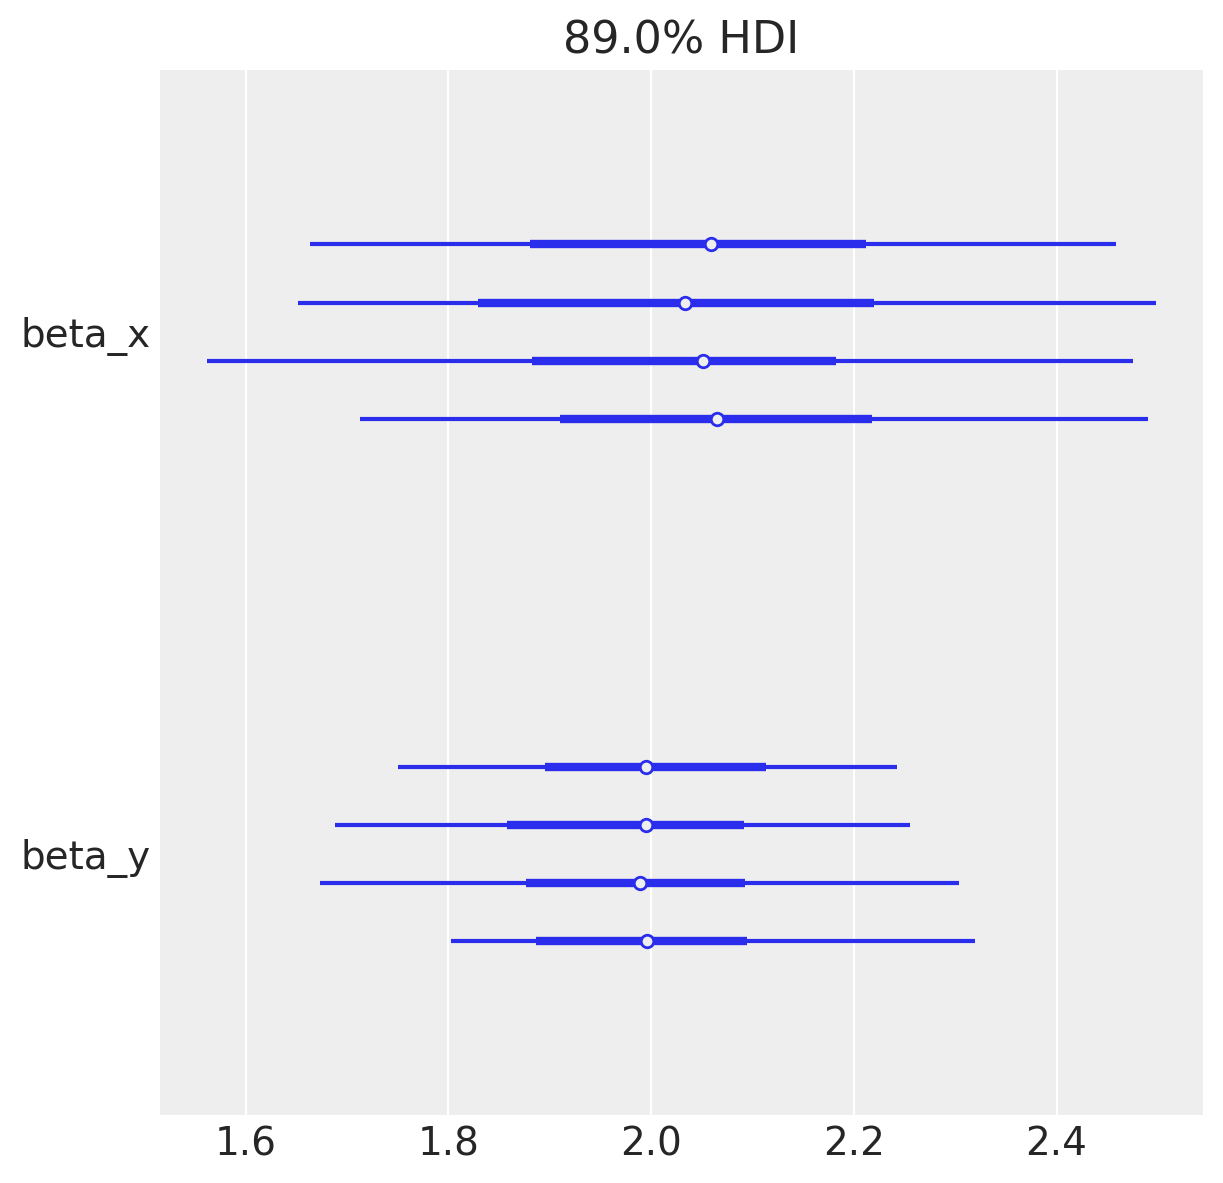

In [18]:
az.plot_forest(sample, var_names=["beta_x", "beta_y"])

When both variables are factored in, there's a positve association between X and Z. Thus, performing both regressions demonstrates the relationship between the two was being masked.

### 5M3.

It is sometimes observed that the best predictor of fire risk is the presence of firefighters — States and localities with many firefighters also have more fires. Presumably firefighters do not cause
fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using multiple regression?

#### Answer 
 It's plausible that a high divorce rate in a state increases the marriage rate via something like the following mechanism. A High divorce rate increase the number of people who are available to get married within a state. These people are now more available to get remarried That is, the high marriage rate is dragged up by people being divorced. Essentially this would be a marriage market with a high turnover rate. This is not immediately testable with multiple regression as there are only two variables of direct causation that concern us here, and question is which way the arrow of causation points. Regression can't solve this problem for us, only further scientific reasoning can do that.

### 5M4.

In the divorce data, States with high numbers of members of the Church of Jesus Christ of Latter-day Saints (LDS) have much lower divorce rates than the regression models expected. Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

I found LDS population data on wikipedia at https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States). Accessed on 20/09/2020.

In [19]:
data = pd.read_csv("./../data/WaffleDivorce.csv", delimiter=";")

In [20]:
LDS = pd.read_csv("./wikipedia_lds.csv")

In [21]:
# Rename the column names to make data sets cohere
col_names = LDS.columns.values
col_names[0] = "Location"
LDS.columns = col_names

In [22]:
# combine data and retain only the states that are in both data sets
combined = pd.merge(data, LDS, on=["Location"])

In [23]:
combined.head(5)

,Location,Loc,Population_x,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,...,Population_y,LDS,Temples,Missions,Districts,Stakes,Wards,Branches,Congregations,Family History Centers
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,...,"4,903,185",0.77%,1,1,0,8,48,28,76,44
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,...,"731,545",4.58%,1,1,0,8,59,21,80,15
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,...,"7,278,717",6.00%,6,6,0,115,842,84,926,74
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,...,"3,017,804",1.07%,0,2,0,7,46,23,69,25
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,...,"39,512,223",1.91%,7,15,0,153,"1,092",137,"1,229",228


We can now attempt to factor the LDS data as an additional predictor variable of divorce rate using the following model:

$CIQ_i$ ~ $N(\mu_i,\sigma^2)$

$\mu_i = \alpha + \beta_{M}M_i + \beta_{A}A_i + \beta_L L_i  $

$\alpha$ ~ $N(0,0.2)$

$\beta_{M}$ ~ $N(0,0.5)$

$\beta_{A}$ ~ $N(0,0.5)$

$\beta_{L}$ ~ $N(0,0.5)$

$\sigma$ ~ $Exp(1)$



In [24]:
scaled_age = (combined.MedianAgeMarriage.values - np.mean(combined.MedianAgeMarriage)) / np.std(
    combined.MedianAgeMarriage
)
scaled_marriage = (combined.Marriage.values - np.mean(combined.Marriage)) / np.std(
    combined.Marriage
)

In [25]:
combined.LDS.values

array(['0.77%', '4.58%', '6.00%', '1.07%', '1.91%', '2.61%', '0.45%',
       '0.58%', '0.45%', '0.75%', '0.82%', '5.30%', '25.86%', '0.45%',
       '0.68%', '0.90%', '1.32%', '0.80%', '0.64%', '0.82%', '0.72%',
       '0.41%', '0.45%', '0.59%', '0.73%', '1.18%', '4.73%', '1.30%',
       '0.65%', '0.38%', '3.31%', '0.43%', '0.85%', '1.52%', '0.54%',
       '1.24%', '3.64%', '0.41%', '0.40%', '0.80%', '1.20%', '0.77%',
       '1.25%', '66.32%', '0.74%', '1.13%', '3.80%', '0.96%', '0.47%',
       '11.70%'], dtype=object)

In [26]:
LDS = np.array([float(word[:-1]) for word in combined.LDS.values])
scaled_LDS = (LDS - np.mean(LDS)) / np.std(LDS)

In [27]:
# Fit the multivariate model
with pm.Model() as Linreg:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_M = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta_M
    beta_A = pm.Normal("beta_A", mu=0, sd=0.5)  # prior on beta_A
    beta_L = pm.Normal("beta_L", mu=0, sd=0.5)  # prior on beta_L
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_M * scaled_marriage + beta_A * scaled_age + beta_L * scaled_LDS
    divorce = pm.Normal(
        "divorce", mu=mu, sd=sigma, observed=combined.Divorce
    )  # likelihood of the data
    sample = pm.sample(
        draws=1000, chains=4, return_inferencedata=True
    )  # 1000 random samples on 4 chains
az.summary(sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_L, beta_A, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.263,0.233,8.914,9.638,0.004,0.003,3135.0,3135.0,3229.0,2728.0,1.0
beta_M,0.150,0.254,-0.268,0.548,0.005,0.004,2898.0,2460.0,2915.0,2853.0,1.0
beta_A,-0.997,0.258,-1.400,-0.577,0.005,0.004,2705.0,2690.0,2692.0,2370.0,1.0
beta_L,-0.443,0.222,-0.768,-0.050,0.004,0.003,3316.0,3316.0,3322.0,3034.0,1.0
sigma,1.493,0.176,1.210,1.746,0.003,0.002,2798.0,2762.0,2828.0,2478.0,1.0


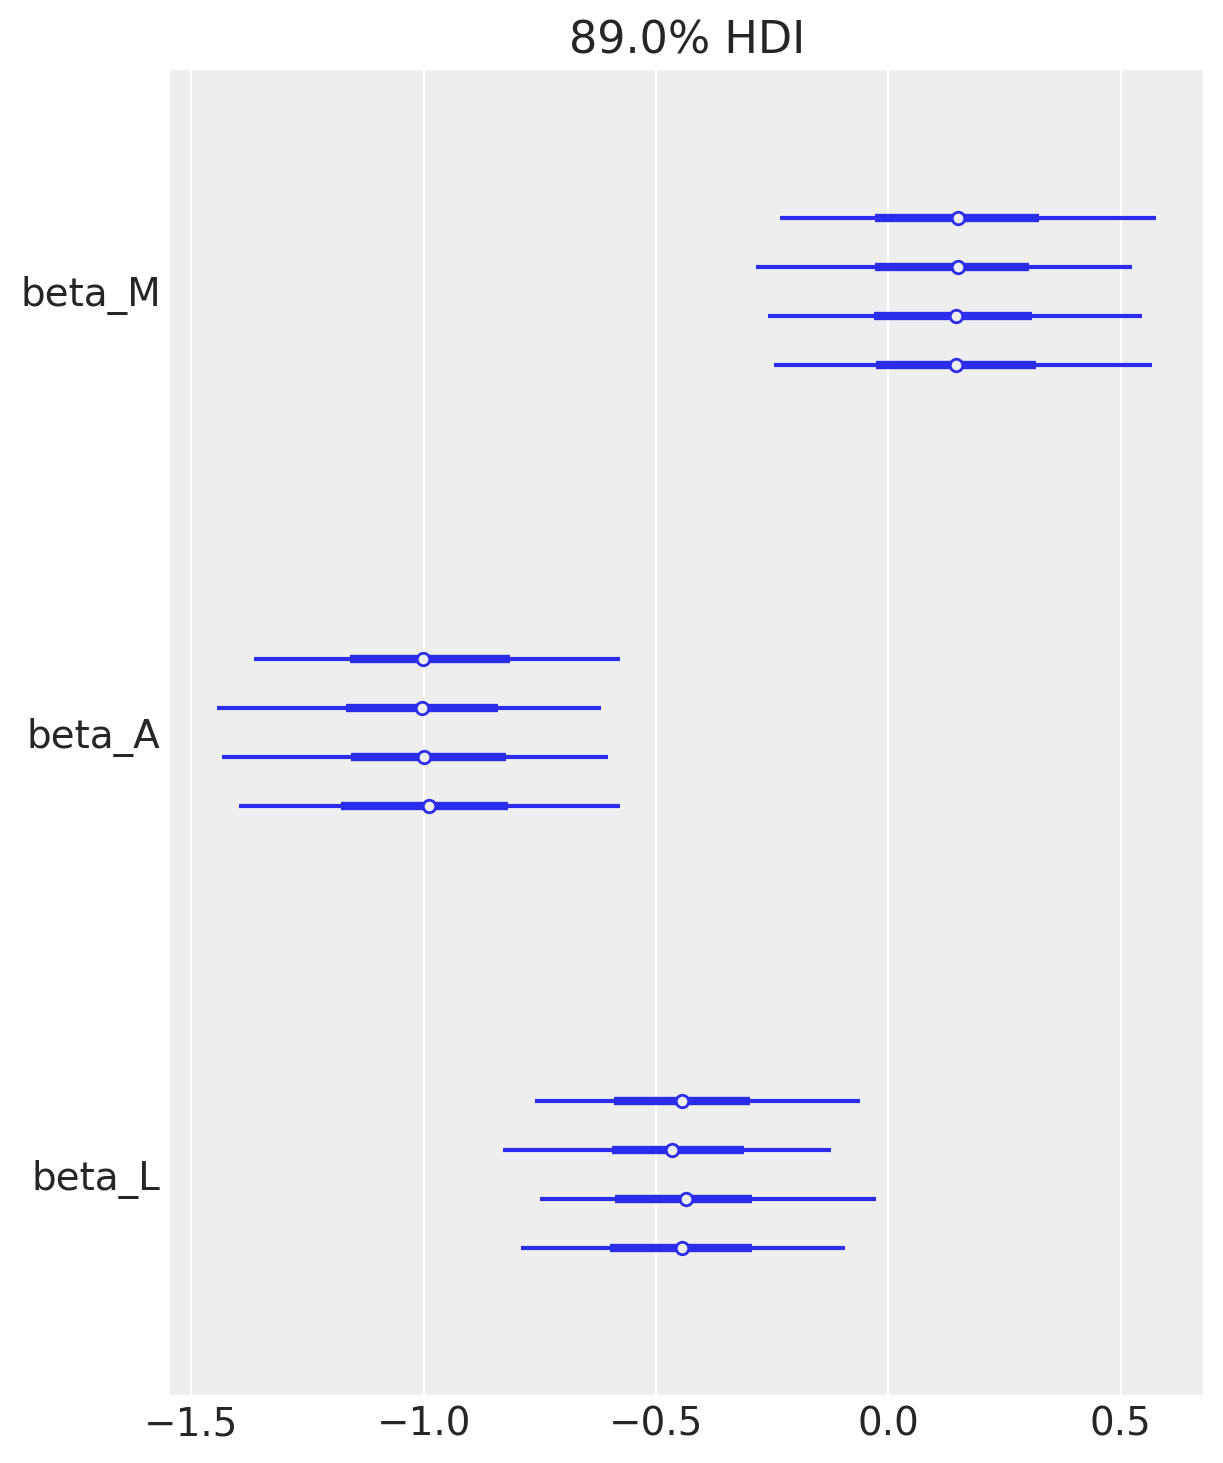

In [28]:
az.plot_forest(sample, var_names=["beta_M", "beta_A", "beta_L"]);

The posterior corroborates the claim the states with higher LDS proportions have lower divorce rates. The HPDI for $\beta_l$ lies below and excludes the null value from being plausible when considering all of these factors.

### 5M5.
One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome
variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

We can can define the following random variables
GP: Gas price

DR: Driving rate

E: Amount of exersice

O: Obesity Rate

EO: Eating out

The two mechanisms posed in the question can be represented through the following DAGs

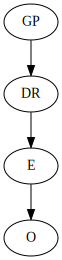

In [29]:
Mechanism1 = CausalGraphicalModel(
    nodes=["GP", "DR", "E", "O"], edges=[("GP", "DR"), ("DR", "E"), ("E", "O")]
)

# draw return a graphviz `dot` object, which jupyter can render
Mechanism1.draw()

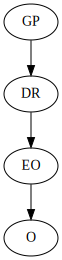

In [30]:
Mechanism2 = CausalGraphicalModel(
    nodes=["GP", "DR", "EO", "O"], edges=[("GP", "DR"), ("DR", "EO"), ("EO", "O")]
)

# draw return a graphviz `dot` object, which jupyter can render
Mechanism2.draw()

### 5H1.
In the divorce example, suppose the DAG is: M → A → D. What are the implied conditional independencies of the graph? Are the data consistent with it?

#### Answer 
 Given A, D is independent of M. That is because M's impact on D is mediated through A in this model, and holding A constant should mean M has no impact on D.


In [31]:
# Fit the multivariate model
with pm.Model() as Linreg:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_M = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta_M
    beta_A = pm.Normal("beta_A", mu=0, sd=0.5)  # prior on beta_A
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_M * scaled_marriage + beta_A * scaled_age
    divorce = pm.Normal("divorce", mu=mu, sd=sigma, observed=data.Divorce)  # likelihood of the data
    sample = pm.sample(
        draws=1000, chains=4, return_inferencedata=True
    )  # 1000 random samples on 4 chains
az.summary(sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.215,0.252,8.821,9.624,0.005,0.004,2521.0,2521.0,2584.0,2175.0,1.0
beta_M,0.026,0.265,-0.413,0.423,0.006,0.004,1979.0,1979.0,1997.0,2544.0,1.0
beta_A,-0.882,0.270,-1.286,-0.443,0.006,0.004,1904.0,1870.0,1910.0,2088.0,1.0
sigma,1.591,0.188,1.287,1.870,0.004,0.003,2296.0,2263.0,2447.0,2657.0,1.0


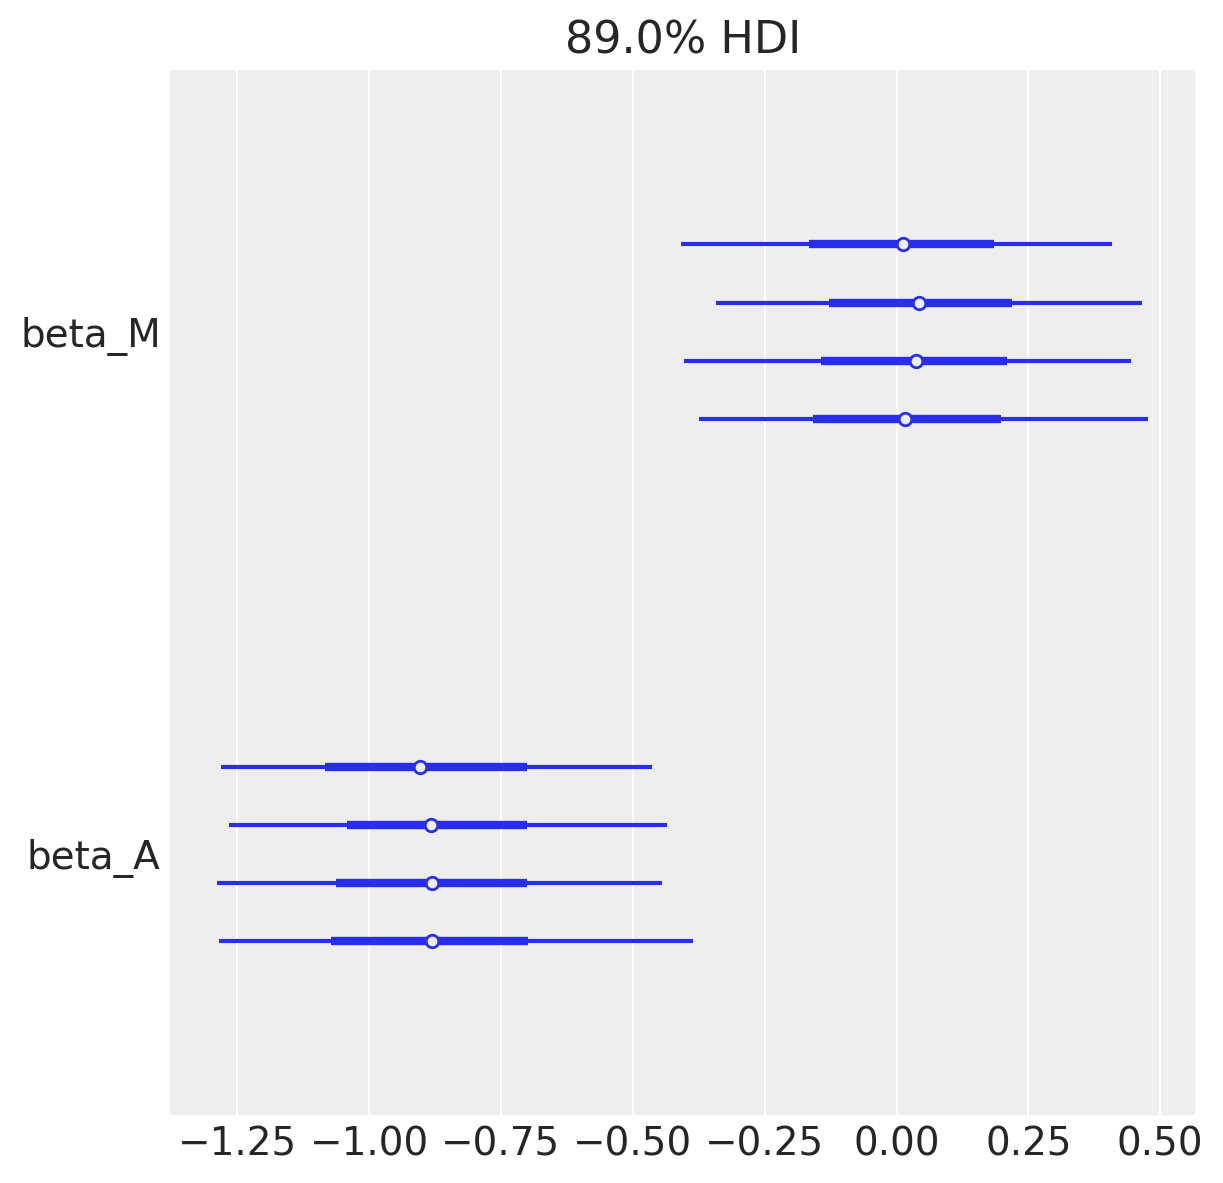

In [32]:
az.plot_forest(sample, var_names=["beta_M", "beta_A"]);

As can be seen, this is consistent with M being conditionally independent of D, as the posterior value on the strength of the association is very consistent with there being no association between M & D when A is included as a predictor in the model.

### 5H2.
Assuming that the DAG for the divorce example is indeed M → A → D, fit a new model and use it to estimate the counterfactual effect of halving a State’s marriage rate M. Use the counterfactual example from the chapter (starting on page 140) as a template.

#### Answer

In order to produce the counter factual plots, one needs to measure the strength of all the associations as implied by the model. We need to find the strength of the dependencies between M and A, then the strength of the association beween A and D. Then we can modify the value of M and see how this propagates through the DAG. I'll be using the quadratic approximation to obtain the predictive plots.

In [33]:
# Fit model1 M-> A
with pm.Model() as Linreg1:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_M = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta_M
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_M * scaled_marriage
    # likelihood of the data
    Age = pm.Normal("age", mu=mu, sd=sigma, observed=scaled_age)
    # 100 random samples on 4 chains
    model1_post = pm.sample(draws=100, chains=4, return_inferencedata=True)
az.summary(model1_post)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.010,0.103,-0.127,0.186,0.005,0.005,515.0,260.0,520.0,261.0,1.01
beta_M,-0.692,0.101,-0.834,-0.530,0.005,0.003,434.0,429.0,436.0,250.0,1.00
sigma,0.718,0.072,0.600,0.826,0.004,0.003,369.0,356.0,391.0,253.0,1.01


In [34]:
# Fit model2 A -> D
with pm.Model() as Linreg1:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_A = pm.Normal("beta_A", mu=0, sd=0.5)  # prior on beta_M
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_A * scaled_age
    divorce = pm.Normal("divorce", mu=mu, sd=sigma, observed=data.Divorce)  # likelihood of the data
    # 100 random samples on 4 chains
    model2_post = pm.sample(draws=100, chains=4, return_inferencedata=True)
az.summary(model2_post)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,9.240,0.253,8.857,9.637,0.015,0.011,279.0,279.0,277.0,340.0,1.01
beta_A,-0.897,0.199,-1.210,-0.599,0.010,0.007,378.0,374.0,373.0,294.0,1.00
sigma,1.567,0.184,1.311,1.836,0.011,0.008,274.0,272.0,282.0,234.0,1.01


We now have the posterior distributions for the two relationships in the causal model. We can now start to investigate the impact of interventions under this causal model. Namely, if we set the marriage rate at a certain level in a given state how would this alter the divorce rate, when divorce rate is mediated through age.

In [35]:
# Find a suitable range
np.min(scaled_marriage), np.max(scaled_marriage)

(-1.7591667404919278, 2.815624299190736)

In [36]:
# range from 12 to 32
MR = np.linspace(-2, 3)  # marriage rate
# get the predicted marriages ages
# each row is intervention variable
MA = np.outer(MR, model1_post.posterior["beta_M"]) + model1_post.posterior["alpha"].values.reshape(
    -1, 400
)
Predictions = np.array(
    [
        np.array(
            np.outer(MA[row, :], model2_post.posterior["beta_A"])
            + model2_post.posterior["alpha"].values.reshape(-1, 400)
        ).ravel()
        for row in range(MA.shape[0])
    ]
)

In [37]:
mean_pred = np.mean(Predictions, axis=1)
low_pred = np.quantile(Predictions, 0.055, axis=1)
upper_pred = np.quantile(Predictions, 0.945, axis=1)

In [38]:
unscaled_MR = MR * np.std(data.Marriage) + np.mean(data.Marriage)

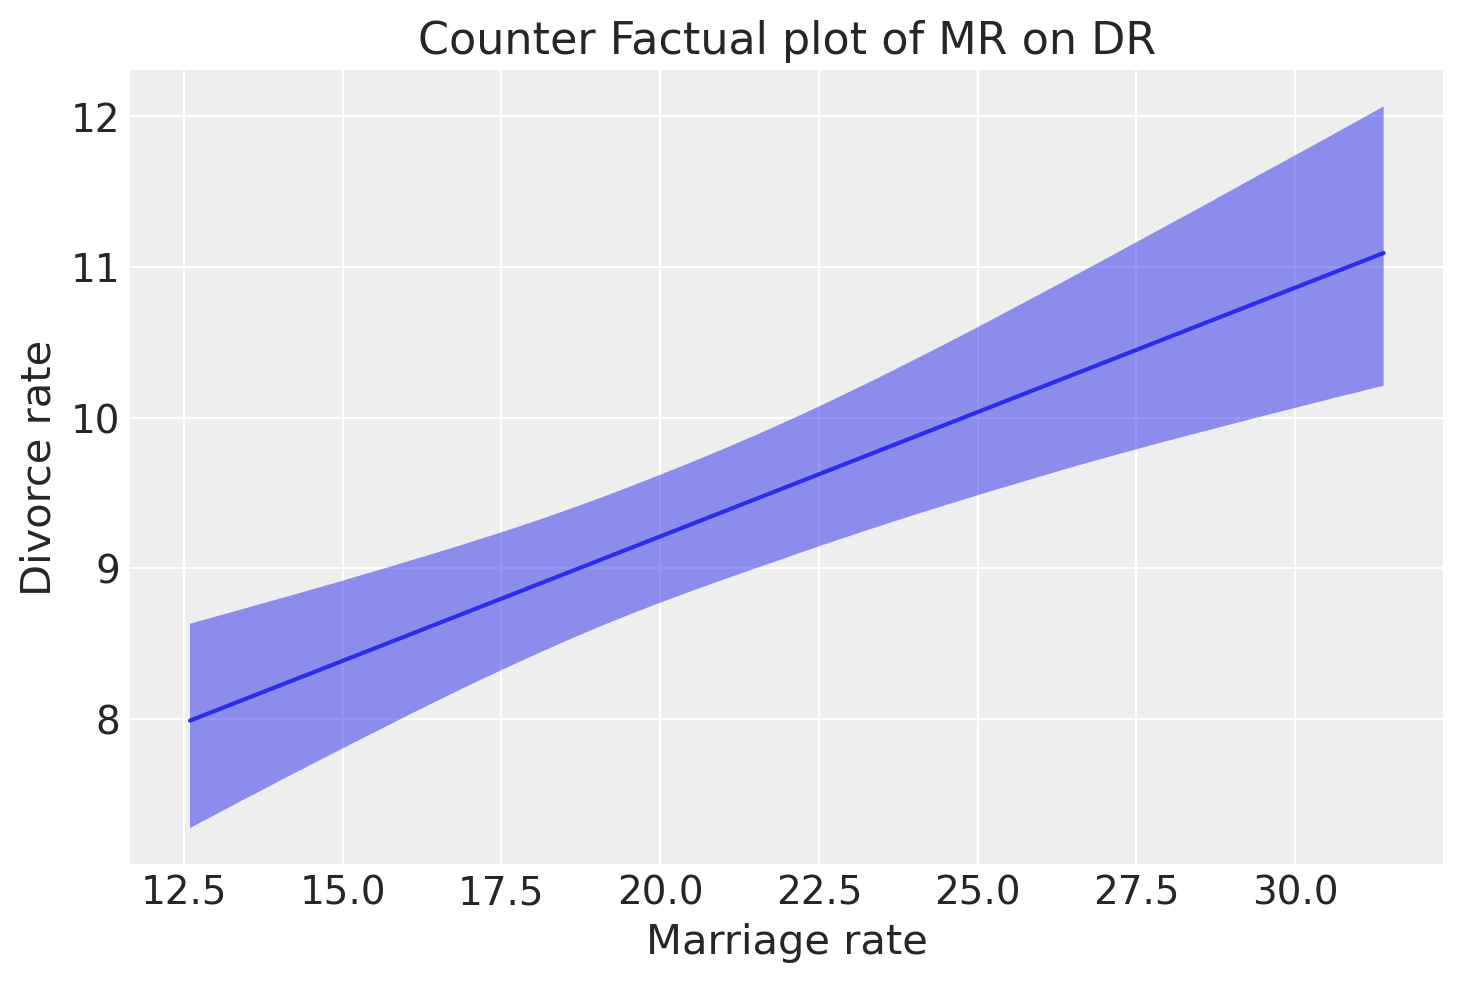

In [39]:
plt.plot(unscaled_MR, mean_pred)
plt.fill_between(unscaled_MR, y1=low_pred, y2=upper_pred, alpha=0.5)
plt.xlabel("Marriage rate")
plt.ylabel("Divorce rate")
plt.title("Counter Factual plot of MR on DR");

### 5H3.
Return to the milk energy model, m5.7. Suppose that the true causal relationship among the variables is:

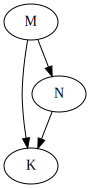

In [40]:
h3 = CausalGraphicalModel(nodes=["M", "N", "K"], edges=[("M", "N"), ("M", "K"), ("N", "K")])

# draw return a graphviz `dot` object, which jupyter can render
h3.draw()

Now compute the counterfactual effect on K of doubling M. You will need to account for both the
direct and indirect paths of causation. Use the counterfactual example from the chapter (starting on page 140) as a template

In [41]:
milk = pd.read_csv("./../data/milk.csv", delimiter=";")

2 models needed here. The effect of M on N. Then the joint effect of N and M on K is also needed.

In [42]:
# perform complete case analysis
milk = milk[~np.isnan(milk["neocortex.perc"])]
scale_M = (milk["mass"] - np.mean(milk["mass"])) / np.std(milk["mass"])
scale_N = (milk["neocortex.perc"] - np.mean(milk["neocortex.perc"])) / np.std(
    milk["neocortex.perc"]
)

In [43]:
# Fit model1 M-> N
with pm.Model() as Linreg1:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_M = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta_M
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_M * scale_M
    # likelihood of the data
    neo = pm.Normal("neo", mu=mu, sd=sigma, observed=scale_N)
    # 100 random samples on 4 chains
    model1_post = pm.sample(draws=500, chains=4, return_inferencedata=True)
az.summary(model1_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.009,0.224,-0.364,0.335,0.005,0.005,1967.0,1029.0,1998.0,1155.0,1.0
beta_M,0.514,0.204,0.209,0.875,0.005,0.003,1923.0,1888.0,1942.0,1423.0,1.0
sigma,0.888,0.169,0.613,1.108,0.004,0.003,1742.0,1670.0,1747.0,1398.0,1.0


In [44]:
# Fit model2 A -> D
with pm.Model() as Linreg1:
    alpha = pm.Normal("alpha", mu=0, sd=1)  # prior on alpha
    beta_M = pm.Normal("beta_M", mu=0, sd=0.5)  # prior on beta_M
    beta_N = pm.Normal("beta_N", mu=0, sd=0.5)  # prior on beta_N
    sigma = pm.Exponential("sigma", lam=1)  # prior on sigma
    mu = alpha + beta_M * scale_M + beta_N * scale_N
    # likelihood of the data
    kcal = pm.Normal("kcal", mu=mu, sd=sigma, observed=milk["kcal.per.g"])
    # 1000 random samples on 4 chains
    model2_post = pm.sample(draws=500, chains=4, return_inferencedata=True)
az.summary(model2_post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_N, beta_M, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.656,0.042,0.595,0.725,0.001,0.001,1529.0,1529.0,1531.0,1228.0,1.0
beta_M,-0.121,0.051,-0.200,-0.039,0.001,0.001,1280.0,1280.0,1274.0,1330.0,1.0
beta_N,0.100,0.052,0.020,0.186,0.001,0.001,1269.0,1269.0,1264.0,1475.0,1.0
sigma,0.163,0.035,0.114,0.215,0.001,0.001,1259.0,1259.0,1296.0,1155.0,1.0


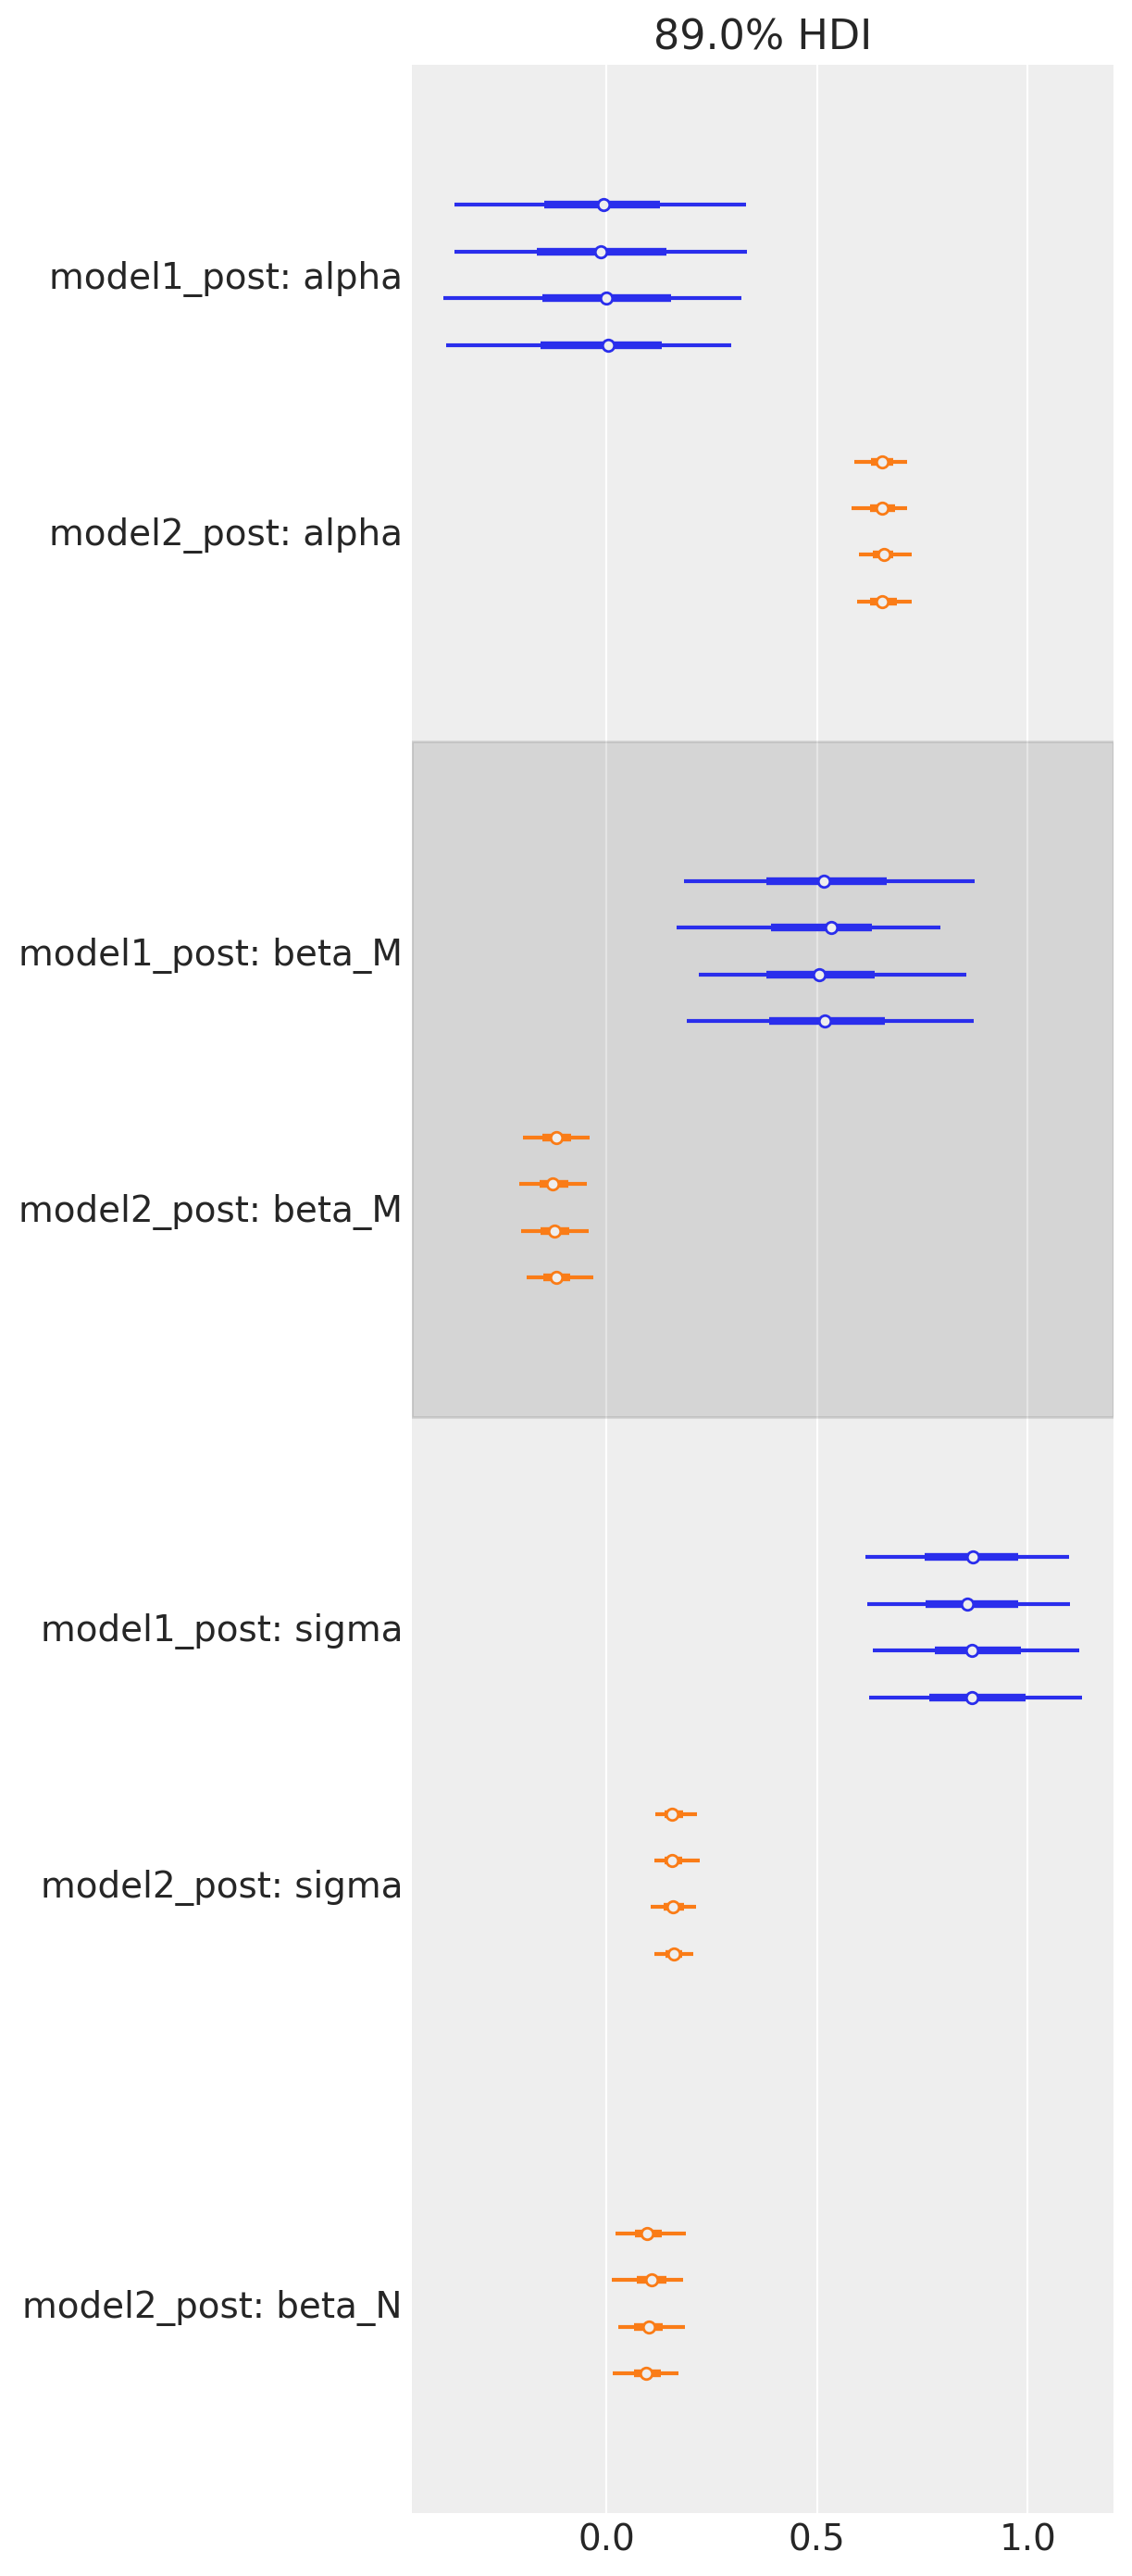

In [45]:
az.plot_forest([model1_post, model2_post], model_names=["model1_post", "model2_post"])
# model 1 interval

We now compute the counterfactual plots as follow:

In [46]:
# find a sensible range of prediction values
np.min(scale_M), np.max(scale_M)

(-0.7219815310503496, 2.7446354164897317)

In [47]:
model1_post.posterior["beta_M"].values.shape

(4, 500)

In [48]:
def N_func(M):
    return model1_post.posterior["alpha"].values.reshape(1, -1) + M * model1_post.posterior[
        "beta_M"
    ].values.reshape(1, -1)

In [49]:
def K_func(M, N):
    return (
        model2_post.posterior["alpha"].values.reshape(1, -1)
        + M * model2_post.posterior["beta_M"].values.reshape(1, -1)
        + np.multiply(N, model2_post.posterior["beta_N"].values.reshape(1, -1))
    )

In [50]:
K = np.array([K_func(M, N_func(M)) for M in np.linspace(-1, 3)])

In [51]:
# get unscaled Marriage coords
Mass = np.linspace(-1, 3) * np.std(milk["mass"]) + np.mean(milk["mass"])

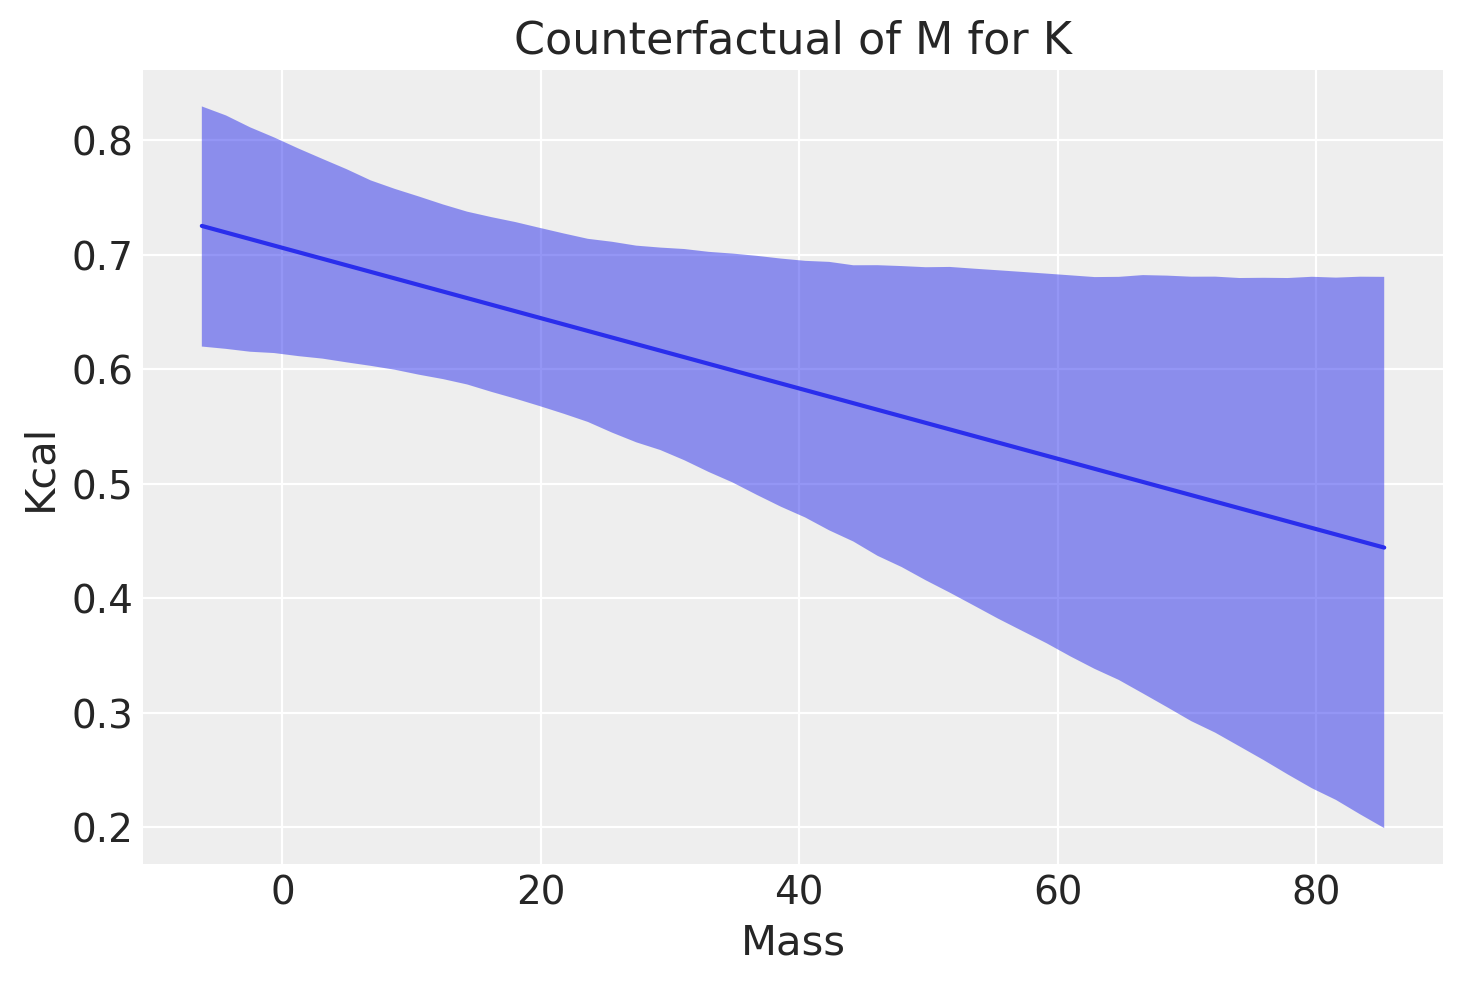

In [52]:
plt.plot(Mass, np.mean(K[:, 0, :], axis=1))
plt.fill_between(
    Mass,
    np.quantile(K[:, 0, :], 0.055, axis=1),
    np.quantile(K[:, 0, :], 0.945, axis=1),
    alpha=0.5,
)
plt.xlabel("Mass")
plt.ylabel("Kcal")
plt.title("Counterfactual of M for K");

In [53]:
%watermark -n -u -v -iv -w

Last updated: Tue Dec 22 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

pymc3     : 3.9.3
arviz     : 0.9.0
seaborn   : 0.11.0
numpy     : 1.19.1
pandas    : 1.1.3
matplotlib: 3.3.2

Watermark: 2.1.0

